# REAP Demo: Router-weighted Expert Activation Pruning

This notebook demonstrates how to use REAP to compress Mixture-of-Experts (MoE) models.

**What is REAP?**
- A one-shot compression method for Sparse Mixture-of-Experts models
- Prunes low-importance experts based on router weights and activation norms
- No retraining required

**Paper:** [REAP: Router-weighted Expert Activation Pruning (arXiv:2510.13999)](https://arxiv.org/abs/2510.13999)

**Code:** [github.com/CerebrasResearch/reap](https://github.com/CerebrasResearch/reap)

## Step 1: Setup & Imports

In [82]:
%pip install torch matplotlib numpy


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: /opt/homebrew/opt/python@3.11/bin/python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [83]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import copy
import time

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

## Step 2: Create Simple MoE Model

We'll build a simple Mixture-of-Experts layer with:
- 8 experts (each a small 3-layer MLP)
- Top-2 routing (each token uses 2 experts)
- Router learns which experts to use for each input

In [84]:
class SimpleMoELayer(nn.Module):
    def __init__(self, d_model=64, num_experts=8, expert_size=32):
        super().__init__()
        self.num_experts = num_experts
        
        # Router: decides which experts to use
        self.gate = nn.Linear(d_model, num_experts)
        
        # Experts: specialized sub-networks
        self.experts = nn.ModuleList([
            nn.Sequential(
                nn.Linear(d_model, expert_size),
                nn.ReLU(),
                nn.Linear(expert_size, d_model)
            )
            for _ in range(num_experts)
        ])
        
    def forward(self, x):
        # x shape: (batch, seq_len, d_model)
        batch_size, seq_len, d_model = x.shape
        x_flat = x.view(-1, d_model)  # Flatten to process per-token
        
        # Get router scores
        router_logits = self.gate(x_flat)
        router_probs = torch.softmax(router_logits, dim=-1)
        
        # Top-2 selection: pick 2 experts per token
        top_k_probs, top_k_indices = torch.topk(router_probs, 2, dim=-1)
        top_k_probs = top_k_probs / top_k_probs.sum(dim=-1, keepdim=True)  # Normalize
        
        # Compute weighted expert outputs
        output = torch.zeros_like(x_flat)
        for i in range(self.num_experts):
            # Find tokens that selected this expert
            mask = (top_k_indices == i).any(dim=-1)
            if mask.any():
                expert_out = self.experts[i](x_flat[mask])
                weights = top_k_probs[mask][top_k_indices[mask] == i]
                output[mask] += expert_out * weights.unsqueeze(-1)
        
        return output.view(batch_size, seq_len, d_model)

model = SimpleMoELayer(d_model=64, num_experts=8, expert_size=32)
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

Total parameters: 34,056


## Step 3: Train on Simple Task

Task: **Predict if the sum of input features is positive or negative**

This gives the experts something meaningful to learn and specialize in.

In [85]:
# Create dataset: binary classification based on mean
def create_simple_dataset(n_samples=1000):
    X = torch.randn(n_samples, 10, 64)
    y = (X.mean(dim=(1, 2)) > 0).float().unsqueeze(1)
    return X, y

X_train, y_train = create_simple_dataset(2000)
X_test, y_test = create_simple_dataset(500)

# Train the model
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()

print("Training model...\n")
model.train()
for epoch in range(50):
    output = model(X_train)
    output_pooled = output.mean(dim=(1, 2)).unsqueeze(1)
    loss = criterion(output_pooled, y_train)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            test_out = model(X_test).mean(dim=(1, 2)).unsqueeze(1)
            test_acc = ((torch.sigmoid(test_out) > 0.5) == y_test).float().mean().item()
        print(f"Epoch {epoch+1:2d} | Loss: {loss.item():.4f} | Test Acc: {test_acc*100:.1f}%")
        model.train()

model.eval()
with torch.no_grad():
    final_out = model(X_test).mean(dim=(1, 2)).unsqueeze(1)
    final_acc = ((torch.sigmoid(final_out) > 0.5) == y_test).float().mean().item()

print(f"\nTraining complete! Final accuracy: {final_acc*100:.1f}%")

Training model...

Epoch 10 | Loss: 0.6891 | Test Acc: 65.6%
Epoch 20 | Loss: 0.6805 | Test Acc: 71.2%
Epoch 30 | Loss: 0.6650 | Test Acc: 79.0%
Epoch 40 | Loss: 0.6396 | Test Acc: 83.6%
Epoch 50 | Loss: 0.6041 | Test Acc: 86.4%

Training complete! Final accuracy: 86.4%


## Step 4: Compute REAP Scores

**REAP Score = Router Weight × Activation Norm**

- High score = Important expert (router trusts it AND it produces strong signals)
- Low score = Can be safely pruned (doesn't meaningfully contribute)

Key implementation details:
- Process per TOKEN (not per sample)
- Only consider top-K selected experts
- Average across all tokens where expert was active

In [ ]:
print("Computing REAP scores...\n")

reap_scores = torch.zeros(model.num_experts)
usage_counts = torch.zeros(model.num_experts)

with torch.no_grad():
    calibration_data = X_train[:500]
    
    # Process per token as per REAP paper
    for batch_idx in range(0, len(calibration_data), 100):
        x = calibration_data[batch_idx:batch_idx + 100]
        
        # x_flat: each row is ONE TOKEN
        x_flat = x.view(-1, 64)
        router_logits = model.gate(x_flat)
        router_probs = torch.softmax(router_logits, dim=-1)
        
        # IMPORTANT: Only top-K experts per token (top-2 routing)
        top_k_probs, top_k_indices = torch.topk(router_probs, 2, dim=-1)
        
        # Compute REAP scores only for experts in top-K
        for expert_idx in range(model.num_experts):
            # mask identifies TOKENS where this expert was in top-K
            mask = (top_k_indices == expert_idx).any(dim=-1)
            
            if mask.sum() > 0:
                router_weights = router_probs[mask, expert_idx]
                expert_out = model.experts[expert_idx](x_flat[mask])
                activation_norms = torch.norm(expert_out, dim=-1)
                
                # REAP score: router_weight × activation_norm (per token)
                reap_scores[expert_idx] += (router_weights * activation_norms).sum()
                usage_counts[expert_idx] += mask.sum()

# Average across TOKENS where expert was active (not samples!)
reap_scores = reap_scores / (usage_counts + 1e-8)

print("="*60)
for i in range(model.num_experts):
    bar = "█" * int(reap_scores[i].item() / reap_scores.max().item() * 40)
    print(f"Expert {i}: {reap_scores[i].item():6.3f} {bar}")
print("="*60)
print("\nHigher REAP score = More important!")

Computing REAP scores...

Expert 0:  2.289 ████████████████████████████████████████
Expert 1:  2.203 ██████████████████████████████████████
Expert 2:  0.756 █████████████
Expert 3:  1.474 █████████████████████████
Expert 4:  1.429 ████████████████████████
Expert 5:  0.908 ███████████████
Expert 6:  1.279 ██████████████████████
Expert 7:  1.756 ██████████████████████████████

Higher REAP score = More important!


### Visualize REAP Scores

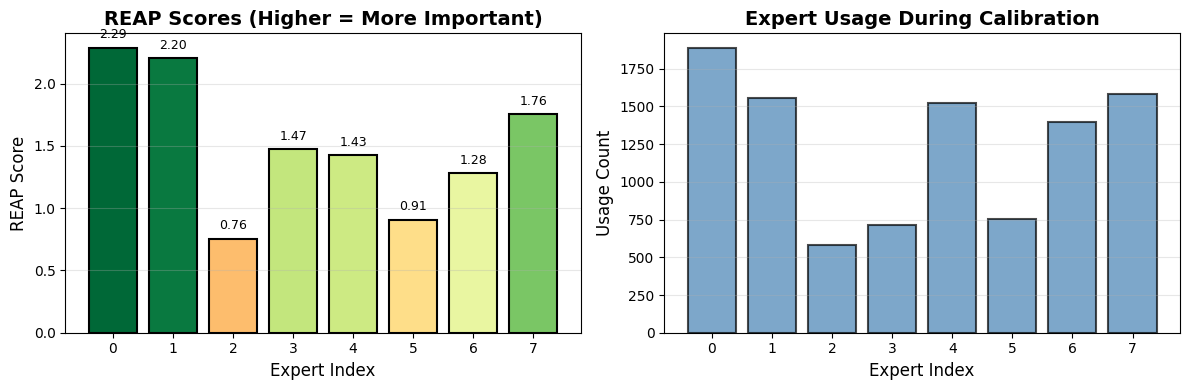

In [87]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot 1: REAP Scores
ax = axes[0]
colors = plt.cm.RdYlGn(reap_scores.numpy() / reap_scores.max().item())
bars = ax.bar(range(8), reap_scores.numpy(), color=colors, edgecolor='black', linewidth=1.5)
ax.set_xlabel('Expert Index', fontsize=12)
ax.set_ylabel('REAP Score', fontsize=12)
ax.set_title('REAP Scores (Higher = More Important)', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
ax.set_xticks(range(8))
for i, (bar, score) in enumerate(zip(bars, reap_scores.numpy())):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
            f'{score:.2f}', ha='center', va='bottom', fontsize=9)

# Plot 2: Usage Count
ax = axes[1]
ax.bar(range(8), usage_counts.numpy(), color='steelblue', alpha=0.7, edgecolor='black', linewidth=1.5)
ax.set_xlabel('Expert Index', fontsize=12)
ax.set_ylabel('Usage Count', fontsize=12)
ax.set_title('Expert Usage During Calibration', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
ax.set_xticks(range(8))

plt.tight_layout()
plt.show()

## Step 5: Prune Lowest-Scoring Experts

Remove the 4 experts with lowest REAP scores (50% reduction in experts = 50% reduction in compute)

In [ ]:
# Find lowest-scoring experts
num_to_prune = 4
_, experts_to_prune = torch.topk(reap_scores, k=num_to_prune, largest=False)
experts_to_keep = [i for i in range(8) if i not in experts_to_prune.tolist()]

print(f"Pruning Decision:")
print(f"  Pruning: {sorted(experts_to_prune.tolist())}")
print(f"  Keeping: {sorted(experts_to_keep)}")

# Save original model before pruning for benchmarking
original_model = copy.deepcopy(model)

# Prune experts: keep only high-scoring ones
model.experts = nn.ModuleList([model.experts[i] for i in sorted(experts_to_keep)])
model.num_experts = len(experts_to_keep)

# Update router: remove rows for pruned experts
with torch.no_grad():
    new_gate = nn.Linear(model.gate.in_features, len(experts_to_keep))
    new_gate.weight.data = model.gate.weight.data[sorted(experts_to_keep), :]
    new_gate.bias.data = model.gate.bias.data[sorted(experts_to_keep)]
    model.gate = new_gate

print(f"\nPruned! Model now has {model.num_experts} experts (was 8)")

Pruning Decision:
  Pruning: [2, 4, 5, 6]
  Keeping: [0, 1, 3, 7]

Pruned! Model now has 4 experts (was 8)


## Step 6: Benchmark & Verify Performance

Compare the original and pruned models across multiple metrics:
- Parameter count & memory footprint
- Inference speed
- Task accuracy

In [ ]:
pruned_model = model

# Parameter count
original_params = sum(p.numel() for p in original_model.parameters())
pruned_params = sum(p.numel() for p in pruned_model.parameters())
original_memory = original_params * 4 / 1024  # KB (4 bytes per float32)
pruned_memory = pruned_params * 4 / 1024

# Speed test
test_input = torch.randn(32, 10, 64)

# Warmup
for _ in range(10):
    _ = original_model(test_input)
    _ = pruned_model(test_input)

# Time original model
start = time.time()
for _ in range(100):
    with torch.no_grad():
        _ = original_model(test_input)
original_time = (time.time() - start) * 1000 / 100  # ms per inference

# Time pruned model
start = time.time()
for _ in range(100):
    with torch.no_grad():
        _ = pruned_model(test_input)
pruned_time = (time.time() - start) * 1000 / 100  # ms per inference

# Print benchmark results
print("Benchmark Results:")
print("="*70)
print(f"{'Metric':<25} {'Original':<15} {'Pruned':<15} {'Reduction':<15}")
print("-"*70)
print(f"{'Experts':<25} {8:<15} {4:<15} {'50%':<15}")
print(f"{'Parameters':<25} {original_params:<15,} {pruned_params:<15,} {(1-pruned_params/original_params)*100:.1f}%")
print(f"{'Memory (KB)':<25} {original_memory:<15.1f} {pruned_memory:<15.1f} {(1-pruned_memory/original_memory)*100:.1f}%")
print(f"{'Speed (ms)':<25} {original_time:<15.3f} {pruned_time:<15.3f} {(1-pruned_time/original_time)*100:.1f}%")
print("="*70)

speedup = original_time / pruned_time

# Task Performance Test
print("\n" + "="*70)
with torch.no_grad():
    # Original model accuracy
    orig_out = original_model(X_test).mean(dim=(1, 2)).unsqueeze(1)
    orig_acc = ((torch.sigmoid(orig_out) > 0.5) == y_test).float().mean().item()
    
    # Pruned model accuracy
    pruned_out = pruned_model(X_test).mean(dim=(1, 2)).unsqueeze(1)
    pruned_acc = ((torch.sigmoid(pruned_out) > 0.5) == y_test).float().mean().item()

print("Task Performance: Predict if sum is positive/negative")
print("="*70)
print(f"{'Model':<25} {'Accuracy':<15}")
print("-"*70)
print(f"{'Original (8 experts)':<25} {orig_acc*100:>6.1f}%")
print(f"{'Pruned (4 experts)':<25} {pruned_acc*100:>6.1f}%")
print(f"{'Difference':<25} {abs(orig_acc-pruned_acc)*100:>6.1f}%")
print("="*70)

print(f"\n{speedup:.2f}x faster, 50% cheaper, with {100-abs(orig_acc-pruned_acc)*100:.1f}% retained accuracy!")

Benchmark Results:
Metric                    Original        Pruned          Reduction      
----------------------------------------------------------------------
Experts                   8               4               50%            
Parameters                34,056          17,028          50.0%
Memory (KB)               133.0           66.5            50.0%
Speed (ms)                1.134           0.854           24.7%

Task Performance: Predict if sum is positive/negative
Model                     Accuracy       
----------------------------------------------------------------------
Original (8 experts)        86.4%
Pruned (4 experts)          83.8%
Difference                   2.6%

1.33x faster, 50% cheaper, with 97.4% retained accuracy!
